# Modeling with the clustering results for the geolocation data

## 0. Libraries and data import

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import gmaps 
import gmaps.datasets
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Perceptron
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from scipy.stats import boxcox
from scipy.spatial import KDTree
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
sns.set_theme()

In [314]:
def clean_data(df):
    df=df.drop(columns=['id', 'date'])
    df = df[df["bedrooms"] <= 8]
    df = df[(df["bathrooms"] < 6) & (df["bathrooms"] >= 1)]
    df = df[df["sqft_living"] <= 6000]
    df = df[df["sqft_lot"] <= 30000]
    df = df[df["sqft_lot15"] <= 30000]
    df.loc[df["view"] != 0, "view"] = 1
    df = df[df["condition"] > 2]
    df.loc[df["sqft_basement"] != 0, "sqft_basement"] = 1
    df.loc[(df["yr_renovated"]!=0)&(df["yr_renovated"]<2000), "yr_renovated"] = 1
    df.loc[df["yr_renovated"]>=2000, "yr_renovated"] = 2
    
    return df

In [315]:
#Data import and cleaning
path = r"..\Data_Midterm.xls"
rs = pd.read_excel(path, engine="xlrd")
rs = clean_data(rs)


## 1. Creating the training and testing datasets

We will eliminate the yr_built and condition columns, since we saw on the modeling part that they are not good for the model's accuracy.

In [316]:
rs = rs.drop(["yr_built", "condition"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(rs.drop("price",axis=1), rs["price"], random_state=1)


## 2. Replicating the clustering exercise

Here we recreate the results from the clustering exercise. We use only the training data. We obtain as a result:
- A dataframe with all the detected centers, which are a location (lat and long) and a price.
- An estimator that will allow us to predict to which cluster each house, in the training and test, sets, belong to. This will allow us to create a column called location_price and add it to our dataset.

In [317]:
#We create the location dataframe with the lat, longitude and price data of the training set.
location = X_train[["lat", "long"]]
location.loc[:,"price"] = y_train


c:\users\carlo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [318]:
#We fit our estimator
estimator = KMeans(n_clusters=250)
estimator.fit(location)


KMeans(n_clusters=250)

Now we need to create the dataframe with the centers that were estimated. Only the training data was used for this dataframe.

In [319]:
#We prepare the data about the clusters that we obtained. We have three lists with lat, long and price data of the clusters,
#and a dataframe with the same values.
long = []
lat = []
price = []
for index, center in enumerate(estimator.cluster_centers_):
    lat.append(center[0])
    long.append(center[1])
    price.append(center[2])

centers_df = pd.DataFrame(data={"lat": lat, "long":long, "price":price})


Now we create the column on the training and testing datasets that will be location_price. First, we estimate to what cluster each house belongs. For that, we need to calculate the minimum distance to one of the centers, and register the price that corresponds to that center. We use the Scipy KDTree method to calculate this values.

In [320]:
#We create the tree that will allow us to quickly calculate which center is the nearest neighbor
tree = KDTree(centers_df[["lat", "long"]])

#We get the distances (not really needed) and the index of the centers that correspond to each point
distance_train, index_train = tree.query(X_train[["lat", "long"]])
distance_test, index_test = tree.query(X_test[["lat", "long"]])



In [321]:
X_train["index_centers"] = index_train
X_test["index_centers"] = index_test

In [322]:
#Finally, we add the column with the location price that corresponds to each center
price_column_train = []
price_column_test = []

for row in X_train.itertuples():
    price_column_train.append(centers_df.loc[row.index_centers, "price"])

for row in X_test.itertuples():
    price_column_test.append(centers_df.loc[row.index_centers, "price"])

X_train["location_price"] = price_column_train
X_test["location_price"] = price_column_test

X_train = X_train.drop("index_centers", axis=1)
X_test = X_test.drop("index_centers", axis=1)

## 1. Creating the dataset that we will be using

We will use this to select different combinations of columns from the dataset:

In [323]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 5358 to 266
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        14640 non-null  int64  
 1   bathrooms       14640 non-null  float64
 2   sqft_living     14640 non-null  int64  
 3   sqft_lot        14640 non-null  int64  
 4   floors          14640 non-null  float64
 5   waterfront      14640 non-null  int64  
 6   view            14640 non-null  int64  
 7   grade           14640 non-null  int64  
 8   sqft_above      14640 non-null  int64  
 9   sqft_basement   14640 non-null  int64  
 10  yr_renovated    14640 non-null  int64  
 11  zipcode         14640 non-null  int64  
 12  lat             14640 non-null  float64
 13  long            14640 non-null  float64
 14  sqft_living15   14640 non-null  int64  
 15  sqft_lot15      14640 non-null  int64  
 16  location_price  14640 non-null  float64
dtypes: float64(5), int64(12)
memor

In [324]:
full_train = X_train
full_test = X_test

In [325]:
X_train = full_train#.drop([""], axis=1)
X_test = full_test#.drop([""], axis=1)

## 2. Applying a Random Forest Regression

Mean squared error: 16465205358.18
Coefficient of determination: 0.86


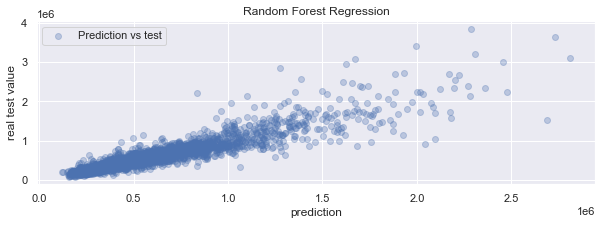

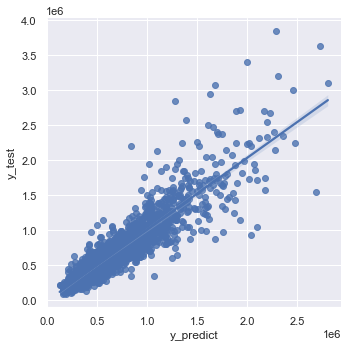

In [326]:
#scaler = StandardScaler()
reg = RandomForestRegressor()
#pipe = make_pipeline(scaler, reg)
reg.fit(X_train, y_train)

y_predict = reg.predict(X_test)

# The coefficients
#print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test,y_predict))

# Plot outputs
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(y_predict, y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='Random Forest Regression')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))

Results obtained:
- All the columns, included location_price: 16.9 MSE, CD 0.85
- No location price: MSE 16.2, CD 0.86. It seems like there is little added value in the clustering exercise, with a number of centers of 2000.
- With location price, but not lat and long: 21 MSE, CD 0.81. The result is worse, so we believe we have to keep the location (lat and long). 
- If we also drop the zipcode, the result is even worse. So we will keep all the location information, including the location_price we discovered with the clustering model.
- Eliminating the waterfront column doesn't help either: MSE 18.5, CD 0.84.
- Eliminating bedroom and bathroom, we lose some precision: MSE 16.8, CD 0.85
- No sqft_lot15: MSE 16.8, CD 0.86
- No yr_renovated: MSE 16.8, CD 0.85
- No view: MSE 16.8, CD 0.85
- No floors: MSE 16.9, CD 0.85
- No waterfront: MSE 18.63 CD 0.84
- No grade: MSE 17.8, CD 0.84

Apparently, with a clustering of 2000 centers, there is no added value with the column location_price.

However, we are going to check the results for different numbers of clusters, and using all the columns, since we have seen there is no apparent added value in dropping any of them.
- 100: MSE 16.3, CD 0.86
- 150: MSE 16.2, CD 0.86
- 200: MSE 16.1, CD 0.86
- 250: MSE 16.1, CD 0.86
- 500: MSE 16.5, CD 0.86
- 1000: MSE 15.97, CD 0.86
- 1500: MSE 16.7, CD 0.86


It seems like the optimum is around 200 clusters. 

## 3. Fine tuning the model's parameters

Hyperparameters are the settings in the algorithm that can be adjusted to optimize performance. Hyperparameters must be set before training. For Random Forest, Scikit-Learn implements a set of sensible default hyperparameters, but we want to see if we can optimize them.

We must be careful to avoid models that overfit. Therefore, the standard procedure for hyperparameter optimization accounts for overfitting through cross validation. We will use the K-fold method, one of the most widely used. 

In [328]:
#These are the default parameters that our previous regressor has.
reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We intend to creat a parameter grid that we will use to optimize, in an iterative and random manner, the most interesting parameters. We will use that grid and use it with RandomizedSearchCV.

In [343]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
n_estimators = [int(x) for x in np.linspace(start=50, stop=250, num=5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 112, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [50, 100, 150, 200, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 24, 39, 53, 68, 82, 97, 112, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


We create the model of the cross validation (it's like any other estimator) and try it with the random forest regressor. We will iterate 100 times, use 3 fold cross validation.

In [344]:
random_forest = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, 
                               n_iter = 50, cv = 2, verbose=2, random_state=1, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 24, 39, 53, 68, 82,
                                                      97, 112, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=1, verbose=2)

The model recommends that we use the following parameters:

In [345]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 97,
 'bootstrap': False}

Before we continue fine tuning, however, we want to see to what extent this "fine tuned model" is better than the base model. So we will compare them by creating an evaluation function

In [388]:
def evaluate(model, test_features, test_labels):
    y_predict = model.predict(test_features)
    errors = abs(y_predict - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    r2 = r2_score(y_test, y_predict)
    print('Model Performance')
    print('Average Abosulute Error: {:0.4f} dollars.'.format(np.mean(errors)))
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict, squared=False))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f\n' % r2)
    
    return accuracy, r2

In [351]:
#Now we create both models and evaluate them:
base = RandomForestRegressor()
base.fit(X_train, y_train)
base_accuracy, base_r2 = evaluate(base, X_test, y_test)
best = rf_random.best_estimator_
random_accuracy, random_r2 = evaluate(best, X_test, y_test)


print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 68983.8106 dollars.
Accuracy = 87.07%.

Model Performance
Average Error: 67107.9589 dollars.
Accuracy = 87.29%.

Improvement of 0.24%.


We have improved the accuracy of the model a little bit. We will try to optimize it even more with a structured search through the parameters that seem best, instead of random:

In [364]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [70, 80, 90, 100],
    'max_features': ["sqrt"],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [200, 250, 300]
}
# Create a based model
r_f = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = r_f, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [365]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [70, 80, 90, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [6, 8, 10, 12],
                         'n_estimators': [200, 250, 300]},
             verbose=2)

In [366]:
grid_search.best_params_


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 250}

These are the parameters that we will use for our future modeling, that will include a new elimination of outliers. Let's see how our base model compares to the "fine tuned one".

In [392]:
#Now we create both models and evaluate them:
base = RandomForestRegressor()
base.fit(X_train, y_train)
base_accuracy, base_r2 = evaluate(base, X_test, y_test)

best = grid_search.best_estimator_
grid_accuracy, grid_r2 = evaluate(best, X_test, y_test)


print('Improvement of {:0.2f}%.'.format(100*(grid_accuracy - base_accuracy)/base_accuracy))


Model Performance
Average Abosulute Error: 69408.5780 dollars.
Mean squared error: 127327.85
Accuracy = 87.01%.
Coefficient of determination: 0.86

Model Performance
Average Abosulute Error: 66820.2420 dollars.
Mean squared error: 122183.80
Accuracy = 87.32%.
Coefficient of determination: 0.87

Improvement of 0.36%.


We display the results of the optimized model:

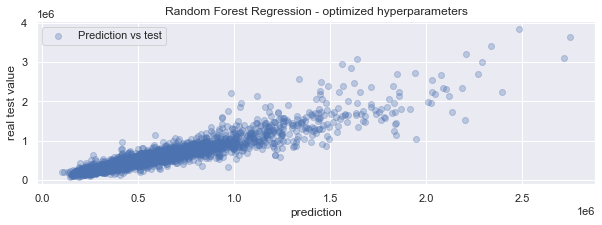

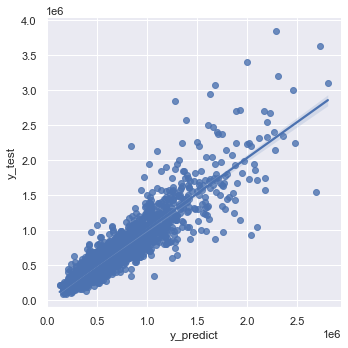

In [382]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(best.predict(X_test), y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='Random Forest Regression - optimized hyperparameters')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))
